In [1]:
%load_ext autoreload
%autoreload 2


import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pvi.models import LogisticRegressionModel
from pvi.clients import Client
from pvi.distributions import MultivariateGaussianDistribution
from pvi.distributions import MultivariateGaussianFactor


import torch
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

from torch import nn

%matplotlib inline
torch.set_default_dtype(torch.float64)

# Set up data and helper functions

In [3]:
x = torch.tensor([[2, 2], [1, 1], [0, 1], [1, 0], [-0.5, 0.1], 
                  [-1, -1], [-2, -2], [0, -1], [-1, 0], [0.5, 0.1]])
y = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.float)

In [4]:
# keyword b deprecated, use visible instead
def plot_data(x, y):
    x_vals = x[:, 0]
    y_vals = x[:, 1]
    labels = y
    
    plt.figure()
    plt.grid(visible=True)
    plt.scatter(x_vals, y_vals, c=labels)
    plt.show()

def plot_results(x, y, client, q):
    x_vals = x[:, 0]
    y_vals = x[:, 1]
    labels = y
    
    q_np1 = q.nat_params["np1"]
    q_np2 = q.nat_params["np2"]
    w_map = (-2 * q_np2).inverse().matmul(q_np1).detach()
    
    plt.figure()
    plt.grid(visible=True)
    plt.scatter(x_vals, y_vals, c=labels)
    plt.arrow(0, 0, w_map[0], w_map[1], head_width=0.1)
    plt.plot([-2, 2], [(w_map[0]/w_map[1])*2, (w_map[0]/w_map[1])*-2])
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure()
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
     
data = {
    "x": x,
    "y": y,
}

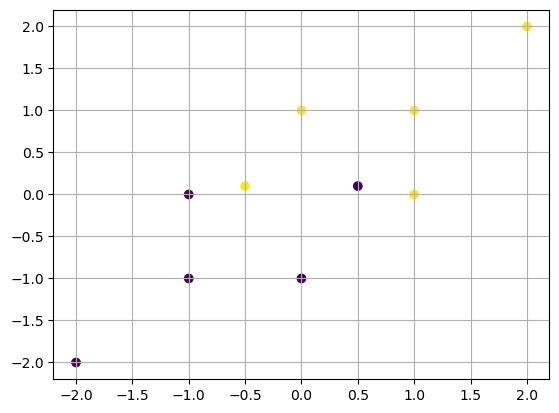

In [5]:
plot_data(x, y)

# Construct logistic regression model

In [6]:
model_config = {
    "D": 2,
}

model = LogisticRegressionModel(config=model_config)

q = MultivariateGaussianDistribution(
    std_params={
        "loc": torch.zeros(model_config["D"] + 1),
        "covariance_matrix": torch.eye(model_config["D"] + 1)
    },
    is_trainable=True,
)

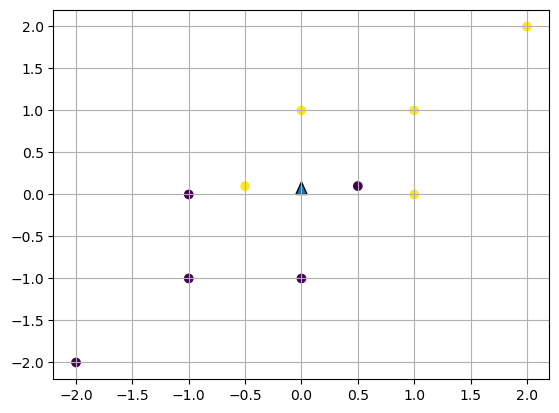

In [7]:
plot_results(x, y, model, q)

# Fit data

In [8]:
t = MultivariateGaussianFactor(
    nat_params = {
        "np1": torch.zeros(model.config["D"] + 1),
        "np2": 0. * torch.eye(model.config["D"] + 1)
    }
)

In [9]:
client_config = {
    "optimiser": "Adam",
    "optimiser_params": {"lr": 1e-3},
    "epochs": 1000,
    "batch_size": 10,
    "num_elbo_samples": 100,
    "num_predictive_samples": 1
}

# Construct client.
client = Client(data=data, model=model, t=t, config=client_config)


## Without optimising model (hyper-)parameters

In [10]:
q_new, t_new = client.update_q(q)

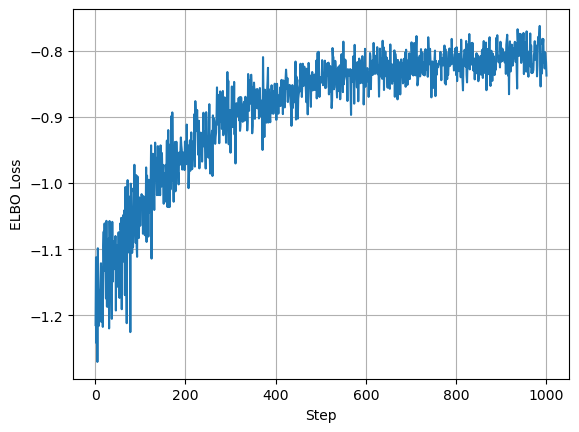

In [11]:
plot_training(client.log["training_curves"][0]["elbo"])

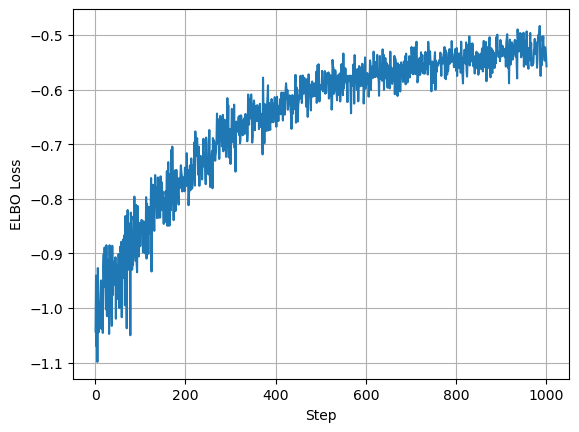

In [12]:
plot_training(client.log["training_curves"][0]["ll"])

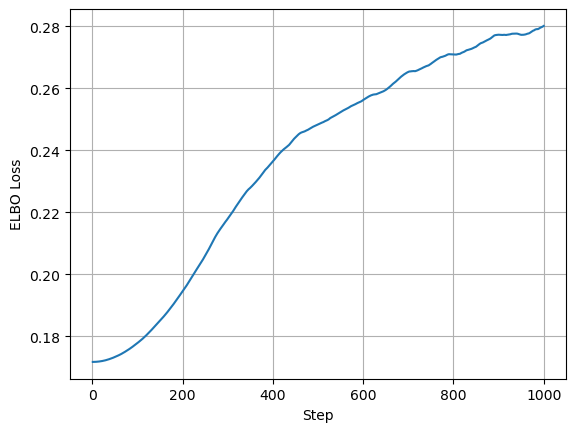

In [13]:
plot_training(client.log["training_curves"][0]["kl"])

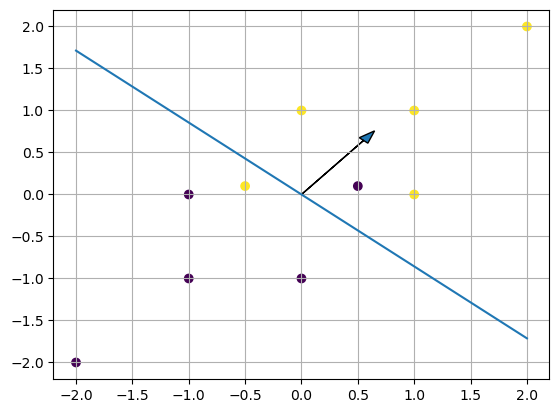

In [14]:
plot_results(x, y, model, q_new)